In [2]:
%load_ext autoreload
%autoreload
%matplotlib inline

import numpy as np
import pandas as pd
from utils import *

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [3]:
# Load data
market_master = load_prices("E:\\diplomka temp\\dataMarket\\GOOGLE\GOOG1min.csv")
tweets = load_tweets("E:\\diplomka temp\\dataProcessed\\tweetsGOOG.csv")

tweets_hour = aggregate_tweets(tweets, 'hour', 'tokens')
tweets_5min = aggregate_tweets(tweets, '5min', 'tokens')
tweets_min = aggregate_tweets(tweets, 'min', 'tokens')
tweets_none = aggregate_tweets(tweets, 'none', 'tokens')

## Creating labels from market data

First of all, we restrict market data to trading hours and bussiness days, otherwise we would get bias because both tweets and stocks follow the same weed and day/night cycles. 


In [4]:
#market = market_master.copy()
#market = market_master[market_master['Tick Count'] > 0]
market = market_master.between_time('9:30', '16:00')

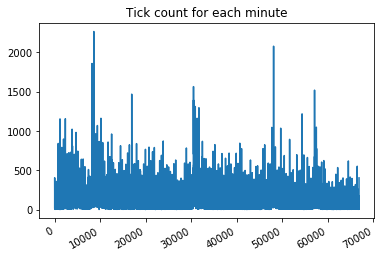

In [5]:
# Plots
market['Tick Count'].plot(use_index=False, title = 'Tick count for each minute')

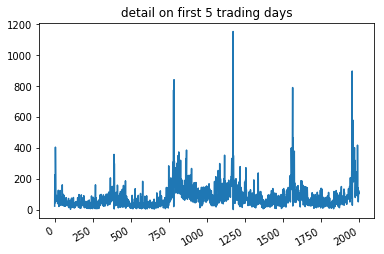

In [6]:
market['Tick Count'].iloc[:2000].plot(use_index=False, title = 'detail on first 5 trading days')

Plots of tick count shows, that there is still some seasonality present. Significant positive outlyers are last minutes of trading day.


## Goals of this section is to create labels from market data
ideas for labels, we can model many different things, such as:

#### Change in price
Try to model change up/down of prices after/before some time
- failed, just noise is there

#### Up Tick minus Down Tick

###### Construction
First, we subtrack down tick from uptick on minute frequency. This value is then split to three categories, based on its quantiles: 0 - 0.33 - 0.66 - 1. Upside of this approach to labeling is having three - category label with equal class distribution as result. Then, we **add lag/lead to the label** and we are ready for modeling.

###### Modeling
In the example, we use 100 minutes of lag to the label. We use twitter minute data as text data. 

Vectorizer is simple Count vectorizer, which is about twice as better (cca 0.01 Kappa) as log TF-IDF with smoothing, which should be the best vectorizer according to IR theory (it has 0.005 Kappa)
Used model is Multinomial NB, as it is fast and reasonably good with high dim data

Since we have equally distributed labels to classes, accuracy is good measure as well

- Results: only cca 1% kappa, so it can be noise
- Results: Results are NOT CHANGING with adding lag or lead to the label (!!!)


In [41]:
label = (market['Up Ticks'] - market['Down Ticks']).rename('label')
label.index = label.index + pd.DateOffset(minutes = 10)

features = tweets_min.join(label, how = 'left').dropna() # we use Twitter minute data
features['label'] = pd.qcut(features['label'], [0, 0.33, 0.66, 1.])  # three category label
features = features.sample(frac=1) # shuffle


# Modeling
vec = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, binary=False)
label = features['label'].astype(str)
train = {}
train['Modeling using text'] = vec.fit_transform(features['text'])
train['Modeling using twitter count'] = pd.DataFrame(features['tweet_count'])
train['Modeling using date/hour/minute'] = pd.DataFrame([features.index.hour.astype(str),
                                                   features.index.minute.astype(str), 
                                                   features.index.dayofweek.astype(str)]).T
for key in train:
    pred = cross_val_predict(MultinomialNB(), train[key], label, cv=5, n_jobs=1, verbose=0)
    print(key)
    evaluate(pred, label)
    print('\n')

Modeling using text
kappa: 0.010871939290335253
accuracy: 0.3563581300943974


Modeling using twitter count
kappa: 0.0
accuracy: 0.39002545185089726


Modeling using date/hour/minute
kappa: 0.0
accuracy: 0.39002545185089726




#### Tick Count

###### Construction
Similar to previous, but we use Total Tick count in given minute to construct the categories. Then similar as previous.

Value is split to four categories, based on quantiles: 0 - 0.25 - 0.5 - 0.75 - 1. Upside of this approach to labeling is having four - category label with equal class distribution as result. Then, we **add lag/lead to the label** and we are ready for modeling.


###### Modeling
Again, we use 100 minutes of lag to the label with twitter minute data as text data. Vectorizer is log TF IDF with smoothing (here is slightly better).

Used model is Multinomial NB, as it is fast and reasonably good with high dim data

- Results: Reasonable accuracy and Kappa, even in the 4 category setting (3 category is even better)
- Experiments: lower twitter frequency means lower kappa/accuracy
- Vectorizers are sensitive to terrible settings (for example that filtering 90% observations means bad results)
- Again, with adding lag or lead to the label the results are NOT CHANGING as expected: With greater temporal distance from tweet, the label is predicted with better accuracy (!!!)


In [56]:
label = market['Tick Count'].rename('label')
label.index = label.index + pd.DateOffset(minutes = 60000)

features = tweets_hour.join(label, how = 'left').dropna() # we use Twitter minute data
features['label'] = pd.qcut(features['label'], [0, .25, .5, .75, 1.])  # four category label
features = features.sample(frac=1) # shuffle

# Modeling
vec = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, sublinear_tf = True, use_idf=True) # best vectorizer according to IR theory
label = features['label'].astype(str)
train = {}
train['Modeling using text'] = vec.fit_transform(features['text'])
train['Modeling using twitter count'] = pd.DataFrame(features['tweet_count'])
train['Modeling using date/hour/minute'] = pd.DataFrame([features.index.hour.astype(str),
                                                   features.index.minute.astype(str), 
                                                   features.index.dayofweek.astype(str)]).T
for key in train:
    pred = cross_val_predict(MultinomialNB(), train[key], label, cv=5, n_jobs=1, verbose=0)
    print(key)
    evaluate(pred, label)
    print('\n')

Modeling using text
kappa: 0.18607065609228546
accuracy: 0.39281437125748503


Modeling using twitter count
kappa: 0.0
accuracy: 0.25988023952095807


Modeling using date/hour/minute
kappa: 0.07206756681669169
accuracy: 0.30538922155688625




# Playground for experiments

In [15]:
#label = market['Tick Count'].rename('label')
label = (market['Up Ticks'] - market['Down Ticks']).rename('label')
label.index = label.index + pd.DateOffset(minutes = 100)

features = tweets_none.join(label, how = 'left').dropna()

#features['label'] = pd.qcut(features['label'], [0, .25, .5, .75, 1.])
#features['label'] = pd.qcut(features['label'], [0, 0.33, 0.66, 1.])
features['label'] = pd.qcut(features['label'], [0, .5, 1.])


In [13]:
features = features.sample(frac=1)

#vec = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, sublinear_tf = True, use_idf=True)
vec = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, binary=False)

label = features['label'].astype(str)
#model = LogisticRegression(C=10,penalty='l2')
model = MultinomialNB()

train = vec.fit_transform(features['text'])
#train = pd.DataFrame(features['tweet_count'])
#train = pd.DataFrame([features.index.hour.astype(str), features.index.minute.astype(str), features.index.dayofweek.astype(str)]).T

pred = cross_val_predict(model, train, label, cv=5, n_jobs=1, verbose=0)
evaluate(pred, label)

kappa: 0.0028066790004239728
accuracy: 0.3482678709370729
